https://medium.com/dair-ai/pytorch-1-2-quickstart-with-google-colab-6690a30c38d

https://github.com/omarsar/pytorch_notebooks/blob/master/pytorch_quick_start.ipynb

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms       

In [2]:
print(torch.__version__)

2.4.0+cu118


In [3]:
BATCH_SIZE = 32

## transformations
transform = transforms.Compose(
    [transforms.ToTensor()])

## download and load training dataset
trainset = torchvision.datasets.MNIST(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=2)

## download and load testing dataset
testset = torchvision.datasets.MNIST(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE,
                                         shuffle=False, num_workers=2)

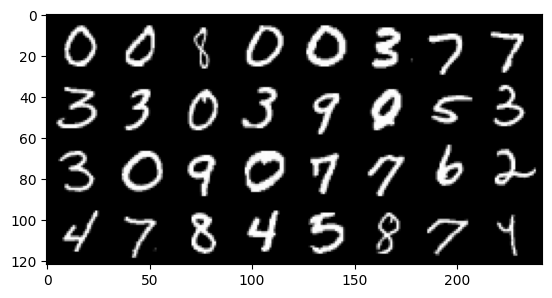

In [4]:
import matplotlib.pyplot as plt
import numpy as np

## functions to show an image
def imshow(img):
    #img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

## get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

## show images
imshow(torchvision.utils.make_grid(images))

In [5]:
for images, labels in trainloader:
    print("Image batch dimensions:", images.shape)
    print("Image label dimensions:", labels.shape)
    break

Image batch dimensions: torch.Size([32, 1, 28, 28])
Image label dimensions: torch.Size([32])


In [6]:
class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()

        # 28x28x1 => 26x26x32
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3)
        self.d1 = nn.Linear(26 * 26 * 32, 128)
        self.d2 = nn.Linear(128, 10)

    def forward(self, x):
        # 32x1x28x28 => 32x32x26x26
        x = self.conv1(x)
        x = F.relu(x)

        # flatten => 32 x (32*26*26)
        x = x.flatten(start_dim = 1)

        # 32 x (32*26*26) => 32x128
        x = self.d1(x)
        x = F.relu(x)

        # logits => 32x10
        logits = self.d2(x)
        out = F.softmax(logits, dim=1)
        return out

In [7]:
## test the model with 1 batch
model = MyModel()
for images, labels in trainloader:
    print("batch size:", images.shape)
    out = model(images)
    print(out.shape)
    break

batch size: torch.Size([32, 1, 28, 28])
torch.Size([32, 10])


In [8]:
learning_rate = 0.001
num_epochs = 30

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = MyModel()
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [10]:
device

device(type='cuda', index=0)

In [11]:
## compute accuracy
def get_accuracy(logit, target, batch_size):
    ''' Obtain accuracy for training round '''
    corrects = (torch.max(logit, 1)[1].view(target.size()).data == target.data).sum()
    accuracy = 100.0 * corrects/batch_size
    return accuracy.item()

In [ ]:
for epoch in range(num_epochs):
    train_running_loss = 0.0
    train_acc = 0.0

    model = model.train()

    ## training step
    for i, (images, labels) in enumerate(trainloader):
        
        images = images.to(device)
        labels = labels.to(device)

        ## forward + backprop + loss
        logits = model(images)
        loss = criterion(logits, labels)
        optimizer.zero_grad()
        loss.backward()

        ## update model params
        optimizer.step()

        train_running_loss += loss.detach().item()
        train_acc += get_accuracy(logits, labels, BATCH_SIZE)
    
    model.eval()
    print('Epoch: %d | Loss: %.4f | Train Accuracy: %.2f' %(epoch, train_running_loss / i, train_acc/i))        

Epoch: 0 | Loss: 1.5516 | Train Accuracy: 91.52
Epoch: 1 | Loss: 1.4909 | Train Accuracy: 97.35
Epoch: 2 | Loss: 1.4814 | Train Accuracy: 98.25
Epoch: 3 | Loss: 1.4762 | Train Accuracy: 98.72
Epoch: 4 | Loss: 1.4733 | Train Accuracy: 98.98
Epoch: 5 | Loss: 1.4718 | Train Accuracy: 99.09
Epoch: 6 | Loss: 1.4703 | Train Accuracy: 99.26
Epoch: 7 | Loss: 1.4693 | Train Accuracy: 99.33
Epoch: 8 | Loss: 1.4688 | Train Accuracy: 99.38
Epoch: 9 | Loss: 1.4679 | Train Accuracy: 99.49
Epoch: 10 | Loss: 1.4677 | Train Accuracy: 99.50
Epoch: 11 | Loss: 1.4668 | Train Accuracy: 99.58
Epoch: 12 | Loss: 1.4668 | Train Accuracy: 99.57
Epoch: 13 | Loss: 1.4668 | Train Accuracy: 99.58
Epoch: 14 | Loss: 1.4664 | Train Accuracy: 99.61
Epoch: 15 | Loss: 1.4662 | Train Accuracy: 99.64
Epoch: 16 | Loss: 1.4659 | Train Accuracy: 99.68
Epoch: 17 | Loss: 1.4660 | Train Accuracy: 99.64
Epoch: 18 | Loss: 1.4659 | Train Accuracy: 99.66
Epoch: 19 | Loss: 1.4656 | Train Accuracy: 99.70
Epoch: 20 | Loss: 1.4653 | Tra

In [ ]:
test_acc = 0.0

for i, (images, labels) in enumerate(testloader, 0):
    images = images.to(device)
    labels = labels.to(device)
    outputs = model(images)
    test_acc += get_accuracy(outputs, labels, BATCH_SIZE)
        
print('Test Accuracy: %.2f'%( test_acc/i))